In [67]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
import math
import pytorch_lightning as pl
# import lightning as pl

from torch.utils.data import DataLoader, Subset
import torchvision.utils as vutils
from torchvision.transforms import v2

from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

pl.seed_everything(42)

Seed set to 42


42

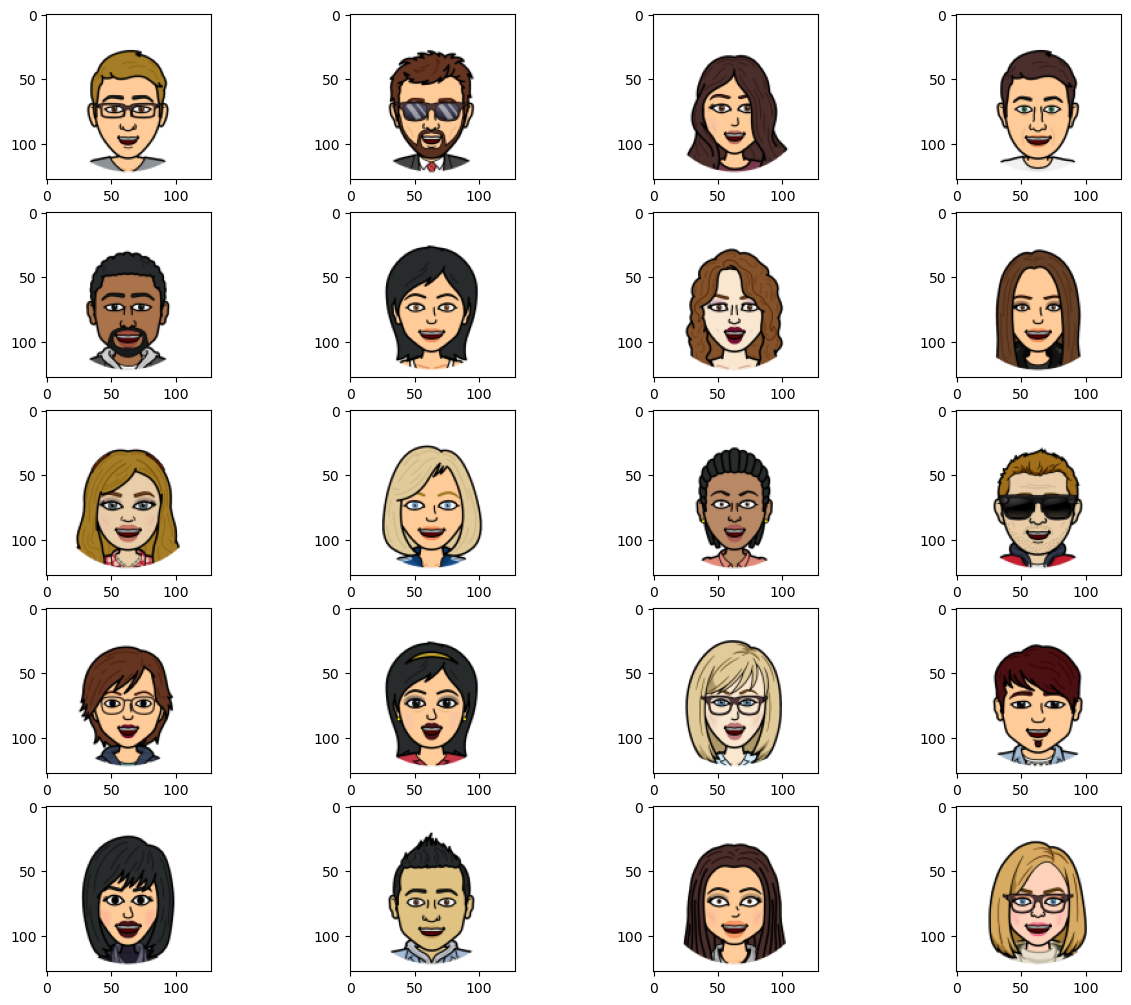

In [68]:
def show_images(datset, num_samples=20, cols=4):
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.ImageFolder(root="/home/maxim/Downloads/archive (4)")
show_images(data)

In [69]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 256

def linear_beta_schedule(timesteps, start=0.00001, end=0.04):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

T = 300
betas = linear_beta_schedule(timesteps=T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [70]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.ImageFolder(root="/home/maxim/Downloads/archive (4)",
                                         transform=data_transform)

    return torch.utils.data.ConcatDataset([train])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: np.clip(t.numpy(), 0, 255).astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image), cmap='gray')

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

/tmp/ipykernel_59424/492072164.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


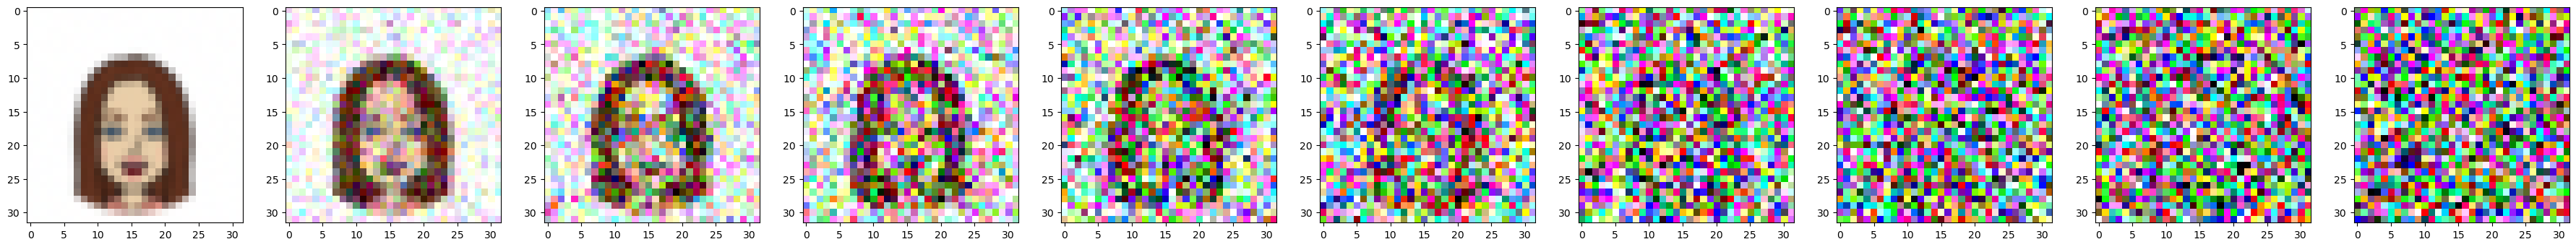

In [71]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(50,50))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [72]:
# class UBlock(nn.Module):
#     def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
#         super().__init__()
#         self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
#         if up:
#             self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
#             self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
#         else:
#             self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#             self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         self.bnorm1 = nn.BatchNorm2d(out_ch)
#         self.bnorm2 = nn.BatchNorm2d(out_ch)
#         self.relu  = nn.ReLU()
        
#     def forward(self, x, t, ):
#         h = self.bnorm1(self.relu(self.conv1(x)))
#         time_emb = self.relu(self.time_mlp(t))
#         time_emb = time_emb[(..., ) + (None, ) * 2]
#         h = h + time_emb
#         h = self.bnorm2(self.relu(self.conv2(h)))
#         return self.transform(h)

In [73]:
# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         return embeddings

In [74]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, "cuda")
    # print("x_noisy nan: " + (torch.isnan(x_noisy.view(-1)).sum().item()==0).__str__())
    # print("noise nan: " + (torch.isnan(x_noisy.view(-1)).sum().item()==0).__str__())
    noise_pred = model(x_noisy, t)
    # print((torch.isnan(noise_pred.view(-1)).sum().item()==0).__str__())
    return F.l1_loss(noise, noise_pred)

In [75]:
@torch.no_grad()
def sample_timestep(x, t, model):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(model):
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device="cuda")
    plt.figure(figsize=(20,20))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device="cuda", dtype=torch.long)
        img = sample_timestep(img, t, model)
        if (i+1) % stepsize == 0:
            plt.subplot(1, num_images, i//stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

In [76]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings


class Unet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (32, 64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64, 32)
        out_dim = 1 
        time_emb_dim = BATCH_SIZE

        self.val_outputs = []
        self.step = 0

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])

        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)
    
    def prepare_data(self):
        transform = transforms.Compose(
            [
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ToTensor(),
            ]
        )

        end_train_idx = int(len(dataloader.dataset) - len(dataloader.dataset) / 5)
        end_val_idx = int(len(dataloader.dataset) - len(dataloader.dataset) / 7)
        end_test_idx = len(dataloader.dataset)

        self.train_dataset = Subset(dataloader.dataset, range(0, end_train_idx))
        self.val_dataset = Subset(dataloader.dataset, range(end_train_idx + 1, end_val_idx))
        self.test_dataset = Subset(dataloader.dataset, range(end_val_idx + 1, end_test_idx))

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=20
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=1, num_workers=20
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=1, num_workers=20
        )
    
    def configure_optimizers(self):
         return torch.optim.Adam(self.parameters(), lr=0.0007)

    def training_step(self, batch, batch_idx):
        x0 = batch[0]
        n = len(x0)
        
        t = torch.randint(0, T, (n,), device="cuda")
        
        loss = get_loss(self, batch[0], t)

        self.step += 1

        if self.step % 400 == 0:
            sample_plot_image(self)
            print(f"Step {self.step:03d} | Loss: {loss.item()}")
            
            dict = self.state_dict()

            dict["pytorch-lightning_version"] = '2.1.0'
            dict["global_step"] = 0
            dict["epoch"] = 0
            dict["state_dict"] = self.state_dict()
            print(dict["global_step"])
            torch.save(dict, "diffusion_model_celeba.ckpt")

        logs = {"loss": loss}
        return {"loss": loss, "log": logs}
    
    def validation_step(self, batch, batch_idx):
        x, _ = batch

        t = torch.randint(T - 5, T, (1,), device="cuda").long()

        output = self(x, t)

        loss = get_loss(self, batch[0], t)

        reverse_transforms = v2.Compose([
            transforms.Lambda(lambda t: (t + 1) / 2),
            transforms.Lambda(lambda t: t.permute(1, 2, 0)),
            transforms.Lambda(lambda t: t * 255.),
            transforms.Lambda(lambda t: np.clip(t.numpy(), 0, 255).astype(np.uint8)),
            transforms.ToTensor()
        ])

        output_img = output[0].cpu()

        self.val_outputs.append(reverse_transforms(output_img))

        self.log("val loss", loss)

        logs = {"loss": loss}
        return {"loss": loss, "log": logs}
    
    def on_validation_epoch_end(self):
        grid = vutils.make_grid(self.val_outputs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

        self.val_outputs.clear()
    
model = Unet()
model

Unet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=256, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=256, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | time_mlp | Sequential | 65.8 K
1 | conv0    | Conv2d     | 896   
2 | downs    | ModuleList | 41.7 M
3 | ups      | ModuleList | 21.6 M
4 | output   | Conv2d     | 99    
----------------------------------------
63.4 M    Trainable params
0         Non-trainable params
63.4 M    Total params
253.426   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

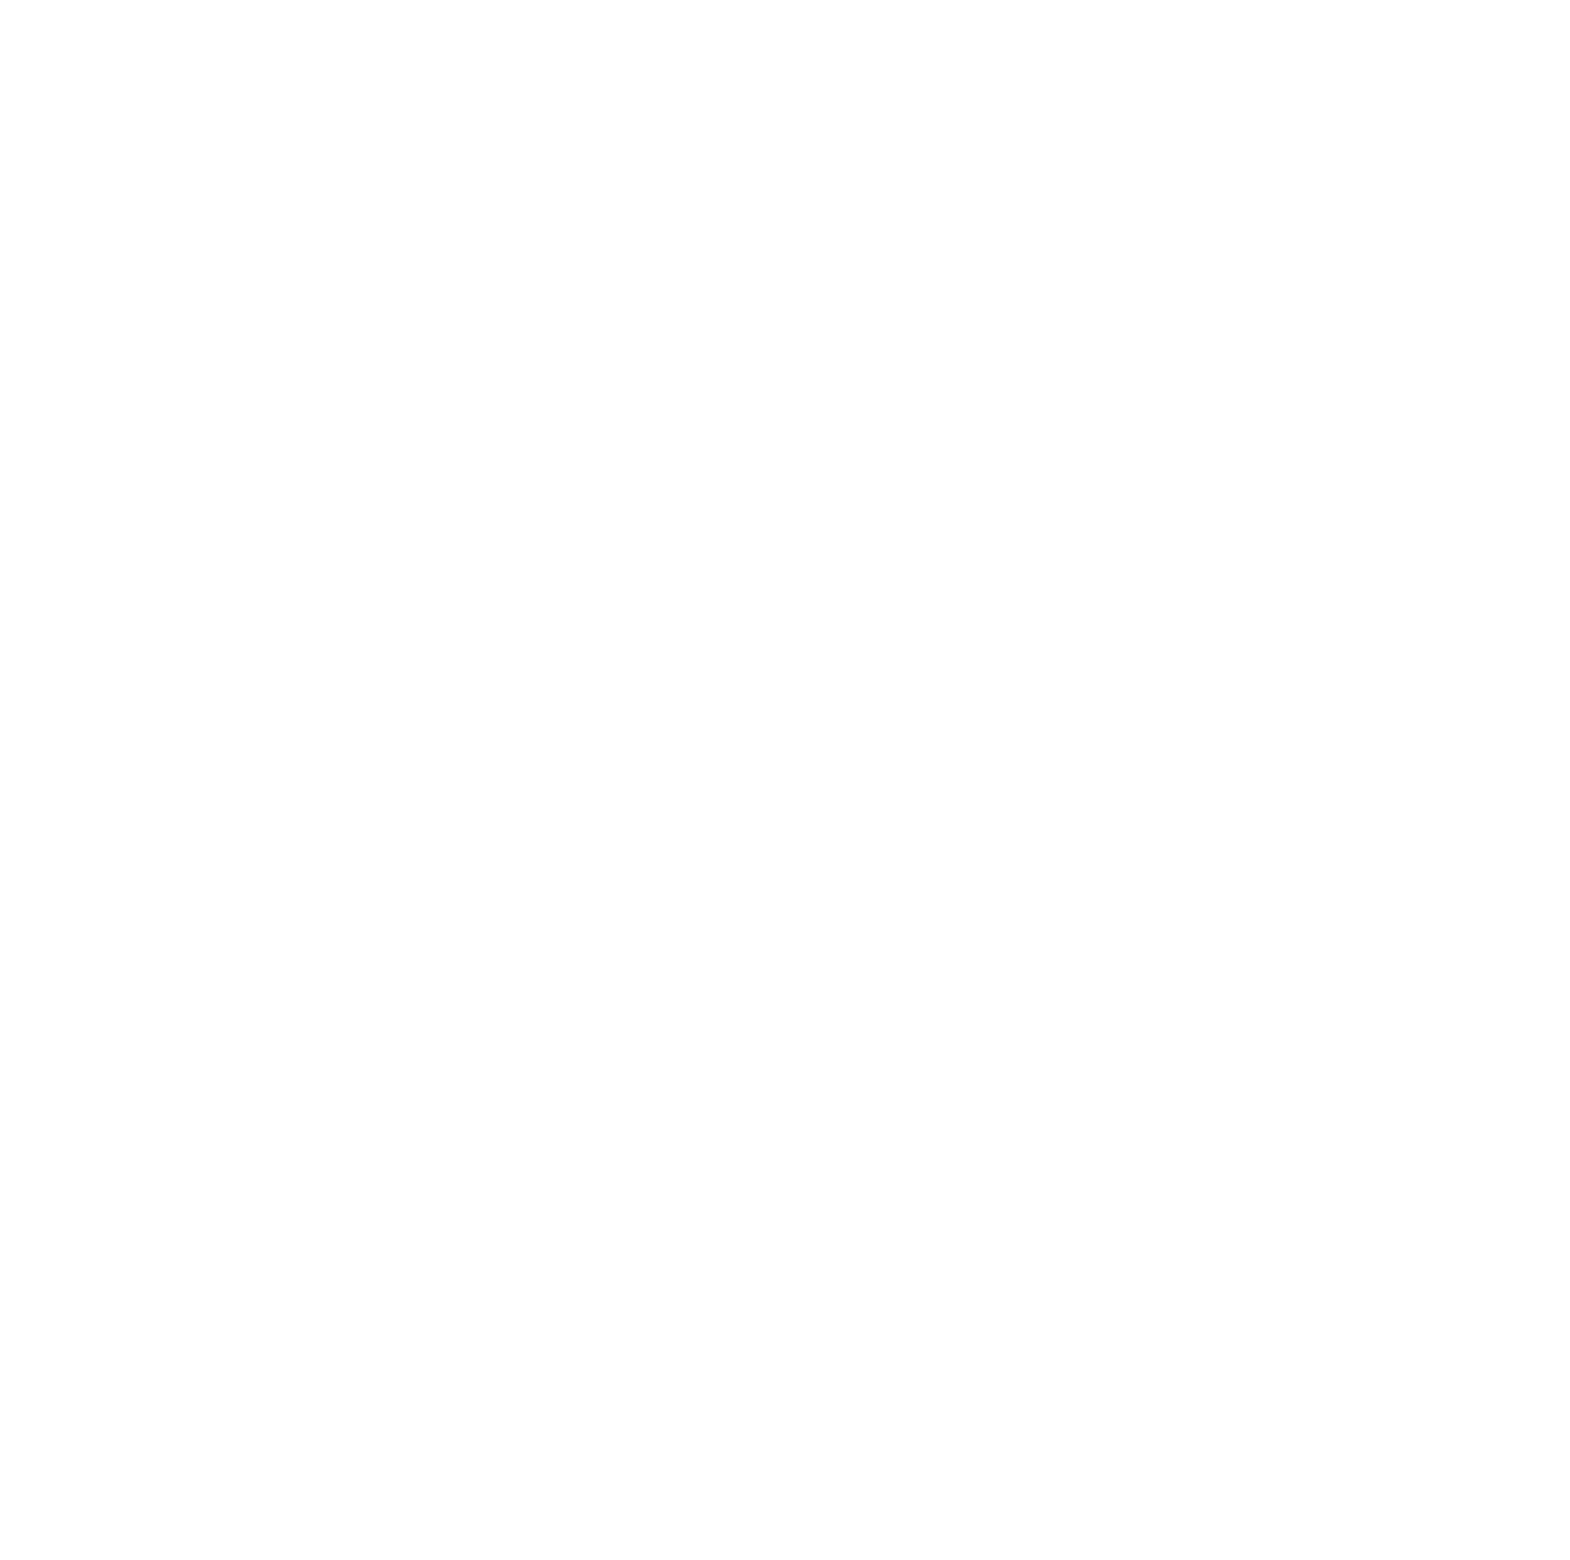

: 

In [77]:
trainer = pl.Trainer(max_epochs=75, precision='16-mixed', accelerator="cuda")

# model = Unet.load_from_checkpoint('/home/maxim/Documents/TestProject/maxim-lightning/diffusion_model_celeba.ckpt')

trainer.fit(model)
trainer.validate(model)

In [ ]:
# @torch.no_grad()
# def sample_plot_image(model, x_0):
#     imgs = []

#     img_noise, img = forward_diffusion_sample(x_0, torch.Tensor([0]).type(torch.int64))
#     for t in range(T):
#         img = model.forward(img, torch.Tensor([t]).type(torch.int64))
#         imgs.append(img[0].cpu())
#         print("t " + t.__str__() + " done!")

#     # reverse_transforms = v2.Compose([
#     #         transforms.Lambda(lambda t: (t + 1) / 2),
#     #         transforms.Lambda(lambda t: t.permute(1, 2, 0)),
#     #         transforms.Lambda(lambda t: t * 255.),
#     #         transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
#     #         transforms.ToTensor()
#     # ])


#     return imgs

In [ ]:
# for idx in range(0, T, stepsize):
#     t = torch.Tensor([idx]).type(torch.int64)
#     plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
#     img, noise = forward_diffusion_sample(image, t)
#     show_tensor_image(img)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1024, 1, 1])

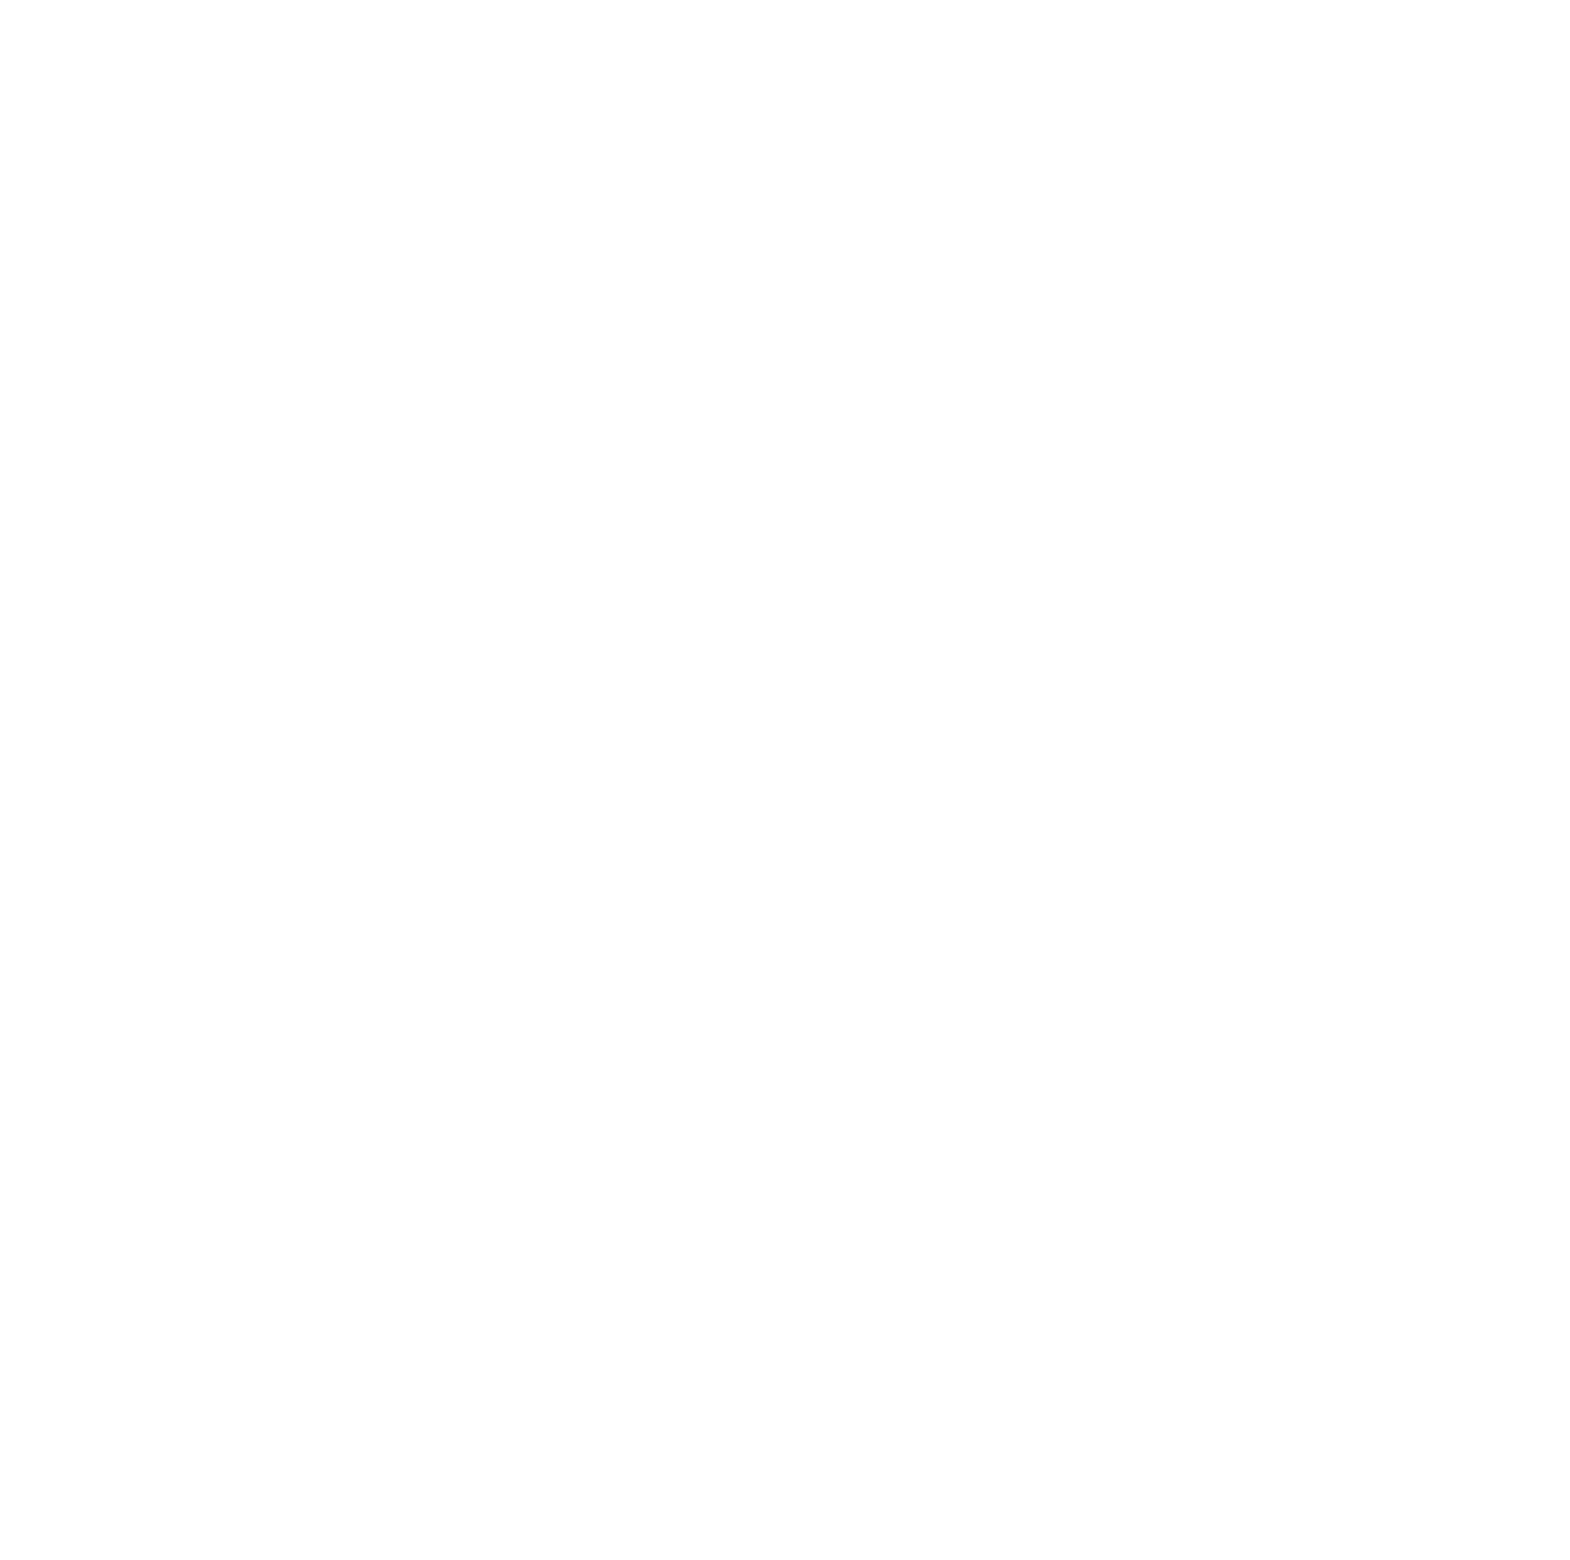

In [ ]:
imgs = sample_plot_image(model.cuda())

In [ ]:
# show_tensor_image()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/